## [영문 분석 + 워드클라우드] 영문 문서 제목의 키워드 분석하기

In [1]:
# ! pip install nltk, wordcloud, xlrd
import nltk

In [6]:
nltk.download() # 최초 한번만 설치: download창이 뜨면, 모두 선택하고 [Download] 버튼 클릭

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [ ]:
import pandas as pd
import glob
import re
from functools import reduce
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
import matplotlib.pyplot as plt
from wordcloud import STOPWORDS, WordCloud

### 1)데이터 준비

In [3]:
# Step1: 데이터 조합 – 파일 병합하기(1000rows * 6columns)

# 만약, *한개로 안되면 **넣으면 되기도 함 버젼차이!
all_files = glob.glob('4.3ref/myCabinetExcelData*.xls') # '*'은 그 뒤에 머가나오든 앞이 동일하면 모-든 파일 가져오란 뜻
all_files 

all_files_data = [] # 저장할 리스트
for file in all_files:
    data_frame = pd.read_excel(file)
    all_files_data.append(data_frame)
    
all_files_data[0] # 이렇게 리스트에 df가 들어가네..? 이거 출력하면 df형태로 보여줌ㄷㄷ;

## 1. 이제 파일 병합하기 -> 이렇게 pd.concat(여러개담긴 리스트)하면 10개 데이터 통합도 되는구나
all_files_data_concat = pd.concat(all_files_data, axis=0, ignore_index=True)
all_files_data_concat

## 2. csv파일로 저장
all_files_data_concat.to_csv('4.3ref/riss_bigdata.csv',encoding='utf-8',index=False)

In [25]:
# Step2: 데이터 전처리

# 1. 수집한 데이터에서 제목을 추출하여 전처리를 수행
all_title = all_files_data_concat['제목'] # (복습)df데이터는 이렇게 하면 제목컬럼의 모든 value가 저장가능ㅇㅇ
# all_title = all_files_data_concat[['제목']] # ! 이렇게 [] 한번더 씌우면 데이터프레임형태로 나옴
type(all_title) # *pandas.core.series.Series -> 그냥 열만 가져왔으니 df가 아니라 series임

all_title

# 2. 전처리 작업을 위해 nltk.corpus에서 제공하는 영어 불용어stopwords.words("english")를 불러와서 저장
stop_words = set(stopwords.words("english")) 

# 2-2. 표제어 추출 작업을 제공하는 WordNetLemmatizer 객체를 생성
lemma = WordNetLemmatizer()
lemma

# 3. 추출작업
'''
1. all_title의 제목에 대해 정규식으로 만든 규칙을 적용하여
- 알파벳으로 시작하지 않는 단어"[^a-zA-Z]+"는 공백으로 치환하여re.sub( ) 제거하고,
2. 소문자로 정규화 하고lower( ), 단어 토큰화word_tokenize( )를 함
3. 그 후, 불용어stopWords를 제거한 후에 표제어 추출lemmatize(w)을 한다.'''
words = []
for title in all_title: 
    EnWords = re.sub(r"[^a-zA-Z]", " ", str(title)) # 1
    EnWordsToken = word_tokenize(EnWords.lower()) # 2
    EnWordsTokenStop = [w for w in EnWordsToken if w not in stop_words] # 3
    EnWordsTokenStopLemma = [lemma.lemmatize(w) for w in EnWordsTokenStop] # 4
    
    words.append(EnWordsTokenStopLemma)

words[0] # 길이는 1000

# 3-2. 전처리가 끝난 words는 2차원 리스트이므로 reduce() 함수를 사용하여 1차원 리스트로 변환
words2 = list(reduce(lambda x,y: x+y, words))
words2 # 길이는 9828임. 1000개제목의 단어들개수

9828

In [ ]:
'''
-잠깐 여기서 의문이 들 수 있다. stop_words는 쳐보면 여러 단어가 있다. are, yourself.. etc..
-언뜻 생각해보면 are같은 be동사는 지우는 것이 이해가 되지만, yourself를 지워야 하나? 이것도 제목의 중요한 요소 아닌가?
-하겠지만, 이 작업의 목적은 "문서 제목의 Keywords를 분석하는 것이다"
-목적을 이해하면, 왜 stop_words들에 포함되어있는 제목 단어들은 다 지우는지 이해가 가능하다
'''

### 2)데이터 탐색 및 분석 모델 구축

In [ ]:
# Step1: 데이터 탐색 - 단어 빈도 구하기
count = Counter(words2)
count # 이렇게 하면, 각 단어(키워드)가 얼마나 등장했는지 알 수 있다. wow;;

word_count = dict()
# key, value가 아니라 tag,counts도 괜찮네
# *counter객체.most_common(n)함수: 상위n개의 것들
for tag, counts in count.most_common(50):
    # ?비록, 키워드길이가 0인건 없지만 해둬서 나쁠건 없어보이긴 하네ㅇㅇ. -> 필요한가? 걸러지지 못한 것들 마무리 용도?
        # ? ask
    if (len(str(tag))>1): 
        word_count[tag] = counts
        print("%s : %d" % (tag, counts))


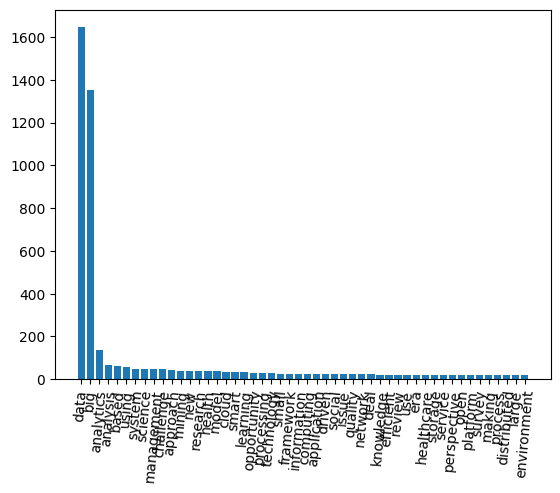

In [38]:
# Step2: 시각화1 - 히스토그램 그리기
sorted_keys = sorted(word_count, key=word_count.get, reverse=True) # get()가 아니네
sorted_values = sorted(word_count.values(), reverse=True)

plt.bar(range(len(word_count)), sorted_values, align='center')
plt.xticks(range(len(word_count)), list(sorted_keys), rotation=85)
plt.show()

# 그런데, 애초에 이 데이터는 big데이터 관련 검색해서 추출해온 엑셀데이터들이기에,
# big, data단어만 빈도수가 엄청 높다 -> 당연한 것
# *따라서, word_count 딕셔너리에서 ‘data’와 ‘big’ 항목을 제거한 경우가 더 가시성이 좋을 것이다!

### 3)결과 시각화

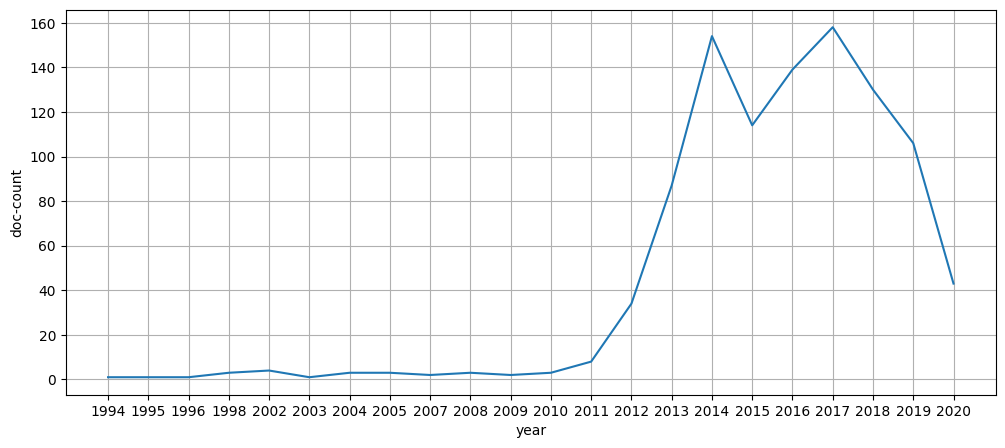

In [42]:
# Step1: 그래프그리기 - groupby이용 -> 출판일 기준으로 그룹화
all_files_data_concat['doc_count'] = 0 # 새 컬럼 추가
# 그룹별 데이터 개수를 count & 기준index로는 안했네
summary_year = all_files_data_concat.groupby('출판일', as_index = False)['doc_count'].count() 
summary_year

plt.figure(figsize=(12,5))
plt.xlabel("year")
plt.ylabel("doc-count")
plt.grid(True)
plt.plot(range(len(summary_year)), summary_year['doc_count'])
plt.xticks(range(len(summary_year)), [text for text in summary_year['출판일']]) # 아에 여기서 comprehension썼네 굿
plt.show()

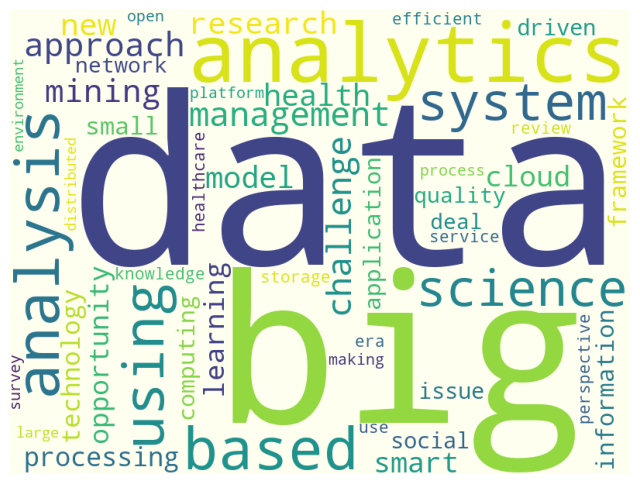

In [46]:
# Step2: '워드 클라우드' 그리기 -> 다양한모양: https://jimmy-ai.tistory.com/135
'''
- 워드클라우드에서 처리할 불용어를 설정하고set(STOPWORDS), 워드클라우드 객체를 생성 WordCloud()
- 워드클라우드 객체인 wc에 word_count 데이터를 담아서 wc.generate_ from_frequencies( ) cloud 객체를 생성
- 생성한 워드클라우드는 matplotlib.pyplot을 사용하여 나타냄
'''
stop_words2 = set(STOPWORDS)
wc = WordCloud(background_color='ivory', stopwords=stop_words2, width=800, height=600) # wc=워드클라우드 약자
cloud = wc.generate_from_frequencies(word_count)
plt.figure(figsize=(8,8))
plt.imshow(cloud) # * imshow
plt.axis('off')
plt.show()

cloud.to_file("4.3ref/riss_bigdata_wordCloud.jpg") # 저장

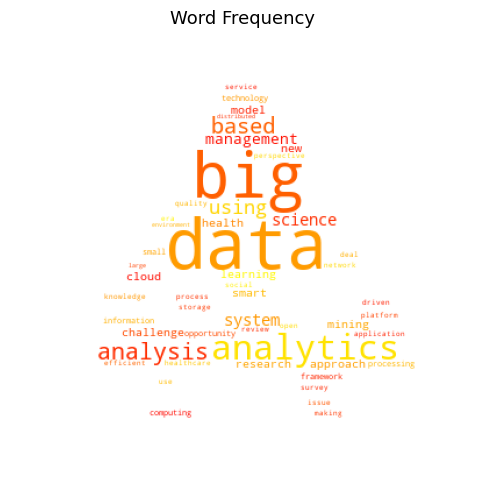

In [51]:
# 이번엔 커스텀모양으로 워드클라우드 그리기
import numpy as np

im = Image.open('4.3ref/triangle.jpg') # 이미지 파일 읽어오기
mask_arr = np.array(im) # 픽셀 값 배열 형태 변환

wordcloud = WordCloud(background_color ='white', colormap='autumn',
                      width = 700, height = 700, random_state = 43, mask = mask_arr,
                      prefer_horizontal = True).generate_from_frequencies(word_count)

plt.figure(figsize = (6, 6))  
plt.imshow(wordcloud)
plt.title("Word Frequency", size = 13)

plt.axis('off')

plt.show()